# Hart85 using Lab Data (3 appliances combination)
- This notebook is written to use the **Hart85 algorithm** to train a model using our lab data
- This allows us to use only the **power dataframe in MultiIndex format** instead of the MeterGroup format from NILMTK to use the algorithm's functions

**Training dataset**
- Model is trained using kettle+vacuum+water_heater 10 mins data
    - Expected to get 3 centroid from clustering (representing 3 'appliances')
    
**Training module steps:**
1. Find steady and transient states
2. Pairing transient states
3. Clustering using mean shift cluster

**Testing dataset:**
1. Disaggregation will be using kettle+vacuum+water_heater 4 mins data
    - Expected that 3 centroids will have predicted load close to kettle and vacuum while 2 other centroids will have 0 load
    
**Disaggregation module steps:**
1. Import trained model
2. Find steady and transients states
3. Disaggregate by chunk
4. Predicted vs ground truth comparison
5. Evaluation

Note: The headings represents the function names found in NILMTK algorithm code

In [1]:
# Importing libraries for working with DataFrames and visualizations
from matplotlib import rcParams
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pickle
import warnings
import time
from collections import OrderedDict, deque

# For evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Importing the following for working with NILM dataset
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.utils import print_dict
from nilmtk.api import API

# Hart85 functions
from nilmtk.disaggregate.hart_85 import Hart85
from nilmtk.feature_detectors.steady_states import find_steady_states
from nilmtk.feature_detectors.cluster import hart85_means_shift_cluster

#plt.style.use('ggplot')
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
# Global variables #
# For API functions
appliances = ["kettle","vacuum", "water heater"]
train_submeters = []
train_mains = []
test_submeters = []
test_mains = pd.DataFrame()
gt_overall = {}
pred_overall = {}
classifiers=[]
errors = []
errors_keys = []
MODEL_NAME = 'Hart85'

# Global variables
# For find states function
noise_level=70
state_threshold=15

# For pairing function
buffer_size=20
min_tolerance=100
percent_tolerance=0.035
large_transition=1000

power = 'active'

metrics = ['mae', 'rmse', 'f1score']
sample_period = 1

In [4]:
# Initiate the Hart85 engine
obj_hart = Hart85({})

# Dataset preparation - Training
Changing lab power data into df that can feed into NILMTK function

- Data     : kettle + vacuum + water heater: has main, kettle, vacuum, water heater load data
- Frequency: 1Hz
- Duration : 10mins 21s
- Pattern: Multiple on/off states

In [5]:
def get_multiIndex(appliance_df, columns):
    df_app = pd.DataFrame(appliance_df['Active (W)'])
    df_app.columns = columns
    df_app.columns.names = ['physical_quantity', 'type']
    df_app.index = pd.to_datetime(df_app.index)
    df_app.index.name = None
    return df_app

In [6]:
# Load main
main_df=pd.read_csv("../Lab_Dataset/3combi_kettle+vacuum+wheater/train_data/main.csv", index_col=0)

# Load submeters
kettle_df=pd.read_csv("../Lab_Dataset/3combi_kettle+vacuum+wheater/train_data/kettle.csv", index_col=0)
vacuum_df=pd.read_csv("../Lab_Dataset/3combi_kettle+vacuum+wheater/train_data/vacuum.csv", index_col=0)
wh_df=pd.read_csv("../Lab_Dataset/3combi_kettle+vacuum+wheater/train_data/water_heater.csv", index_col=0)

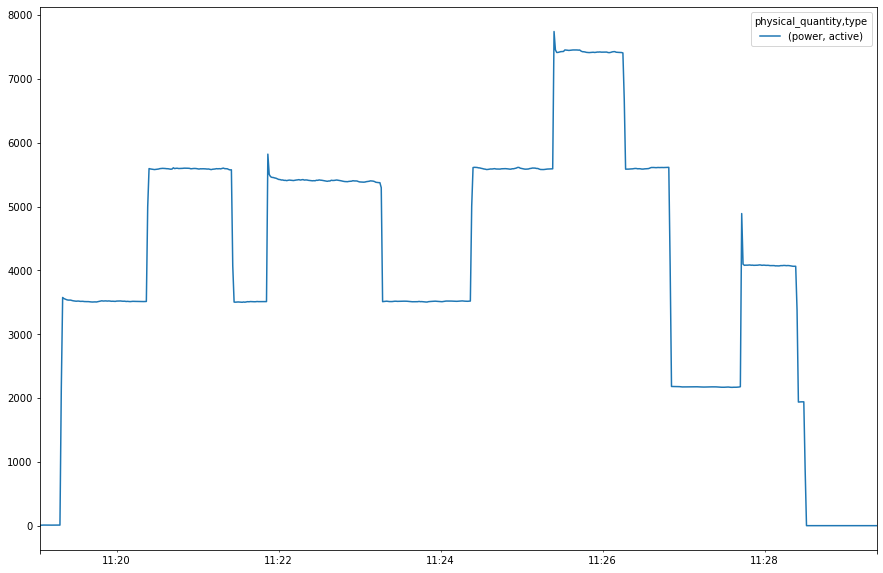

In [7]:
# Convert lab data to multiIndex df
# set column
columns = pd.MultiIndex.from_tuples([('power','active')])

# main
df_main = get_multiIndex(main_df, columns)
# Kettle
df_ke = get_multiIndex(kettle_df, columns)
# Vacuum
df_vac = get_multiIndex(vacuum_df, columns)
# Water Heater
df_wh = get_multiIndex(wh_df, columns)

df_main
df_main.plot()

In [8]:
# Append appliances into one list
appliance_readings = []
appliance_readings.append(df_ke)
appliance_readings.append(df_vac)
appliance_readings.append(df_wh)

In [9]:
# Aggregated load is already in mains, no need to artificial aggregate
train_df = df_main
train_submeters = [[] for i in range(len(appliances))]
train_mains = []

train_mains.append(train_df)
for i,name in enumerate(appliances):
    train_submeters[i].append(appliance_readings[i])

appliance_readings = []
for i,appliance_name in enumerate(appliances):
    appliance_readings.append((appliance_name, train_submeters[i]))

train_submeters = appliance_readings 

# Training
Extracting code from NILMTK API and Hart85 to use for lab data

## Partial Fit
Hart85 partial fit function:

1. Using **find_steady_states_transients** function from Hart85

**Steps to find states:**
    
1. The algorithm will mark the changes in power, if it is higher than the state_threshold, then a transition is happening and the values will be calculated based on the estimated steady state
2. The transients are found by taking the difference between 2 measurements and goes through a nested If:
    - If state change > threshold, then detect that there is transition happening
    - If transition > noise level, then record the transition and steady states
- Transitions are recorded as positive when power is going up and negative when power is going down
- The start of steady states are used as edges for the state change
- Returns the lists of recorded transient and steady states into Dataframe
-------
Pair
Using **PairBuffer** class by calling **pair** function from Hart85
- Pairing is done by taking the transition states values and finding the difference between those values to check which to pair
- The pair function uses a buffer to match the on/off transition
--------------
From Hart's paper:

    For the two-state load monitor, a pair is defined as two entries
    which meet the following four conditions:
        (1) They are on the same leg, or are both 240 V,
        (2) They are both unmarked,
        (3) The earlier has a positive real power component, and
        (4) When added together, they result in a vector in which the
        absolute value of the real power component is less than 35
        Watts (or 3.5% of the real power, if the transitions are
        over 1000 W) and the absolute value of the reactive power
        component is less than 35 VAR (or 3.5%).
-------------
**Steps for pairing:**
   1. Take 2 elements (positive and negative transitions)
   2. Is the addition between these 2 elements more than threshold(min_tolerance)? If power value > 1000W then threshold is 3.5% of the max power value between the 2 elements
   3. The 2 elements that falls within the threshold are paired
   4. The on/off pairing is found according to buffer size, if buffer size is 20 then max finding on/off pair within 20 samples
-----------

In [10]:
def partial_fit(train_main, train_appliances):
    """
    Train using Hart85.
    """

    obj_hart.appliances=[]
    for row in train_appliances:
        obj_hart.appliances.append(row[0])
    print("...........................Hart_85 Partial Fit Running...............")
      
    train_main=train_main[0]
    l=[]
    l.append(train_main.columns[0])
    columns=l
    obj_hart.columns=columns
    obj_hart.state_threshold = state_threshold
    obj_hart.noise_level = noise_level
    [obj_hart.steady_states, obj_hart.transients] = find_steady_states(
        train_main,  noise_level=noise_level, state_threshold=state_threshold)  
    obj_hart.pair_df = obj_hart.pair(
        buffer_size, min_tolerance, percent_tolerance, large_transition)
    obj_hart.centroids = hart85_means_shift_cluster(obj_hart.pair_df, columns)
      
    print('..............................Predicting Centroid Matching..........................')
    chunk=train_main
        
    transients=obj_hart.transients
    temp_df=pd.DataFrame()
    # For now ignoring the first transient
    # transients = transients[1:]

    # Initially all appliances/meters are in unknown state (denoted by -1)
    prev = OrderedDict()
    learnt_meters = obj_hart.centroids.index.values
    for meter in learnt_meters:
        prev[meter] = -1

        
    states = pd.DataFrame(
        -1, index=chunk.index, columns=obj_hart.centroids.index.values)
           
    for transient_tuple in transients.itertuples():
        if transient_tuple[0] < chunk.index[0]:
            # Transient occurs before chunk has started; do nothing
            pass
        elif transient_tuple[0] > chunk.index[-1]:
            # Transient occurs after chunk has ended; do nothing
            pass
        else:
            # Absolute value of transient
            abs_value = np.abs(transient_tuple[1:])
            positive = transient_tuple[1] > 0
            abs_value_transient_minus_centroid = pd.DataFrame(
                (obj_hart.centroids - abs_value).abs())
            if len(transient_tuple) == 2:
                # 1d data
                index_least_delta = (abs_value_transient_minus_centroid.idxmin().values[0])
            else:
                # 2d data.
                # Need to find absolute value before computing minimum
                columns = abs_value_transient_minus_centroid.columns
                abs_value_transient_minus_centroid["multidim"] = (
                    abs_value_transient_minus_centroid[columns[0]] ** 2
                    +
                    abs_value_transient_minus_centroid[columns[1]] ** 2)
                index_least_delta = (
                    abs_value_transient_minus_centroid["multidim"].idxmin())
            if positive:
                # Turned on
                states.loc[transient_tuple[0]][index_least_delta] = 1
            else:
                # Turned off
                states.loc[transient_tuple[0]][index_least_delta] = 0
    prev = states.iloc[-1].to_dict()
    power_chunk_dict = obj_hart.assign_power_from_states(states, prev)
    obj_hart.power_dict = power_chunk_dict
    obj_hart.chunk_index = chunk.index
    # Check whether 1d data or 2d data and converting dict to dataframe
    #print('LEN of Transient Tuple',len(transient_tuple))
    if len(transient_tuple) == 2:
            
        temp_df = pd.DataFrame(power_chunk_dict, index=chunk.index)  
    else:
        tuples = []

        for i in range(len(obj_hart.centroids.index.values)):
            for j in range(0, 2):
                tuples.append([i, j])

        columns = pd.MultiIndex.from_tuples(tuples)

        temp_df = pd.DataFrame(
            power_chunk_dict,
            index=chunk.index,
            columns=columns)

        for i in range(len(chunk.index)):
            for j in range(len(obj_hart.centroids.index.values)):
                for k in range(0, 2):
                    temp_df.iloc[i,j,k] = power_chunk_dict[j,i,k]
        
    obj_hart.best_matches={} 
    temp_df=temp_df.fillna(0)
    best_matches={}
        
    for row in train_appliances:
        appliance=row[0]
        appliance_df=row[1][0]
        matched_col=obj_hart.min_rmse_column(temp_df,appliance_df['power'])
        best_matches[appliance]=matched_col
    obj_hart.best_matches=best_matches        
        
    print('...................................End Centroid Matching............................')

    obj_hart.model = dict(
            best_matches=best_matches,
            columns=columns,
            state_threshold=state_threshold,
            noise_level=noise_level,
            steady_states=obj_hart.steady_states,
            transients=obj_hart.transients,
            centroids=obj_hart.centroids
        )

    print("------------------Hart85 partial_fit end.................")

In [11]:
#Start training
start_time = time.time()

partial_fit(train_mains,train_submeters)

print("---Runtime: %s seconds ---" % (time.time() - start_time))

...........................Hart_85 Partial Fit Running...............
Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.
.........................Hart_85 Partial Fit End....................
..............................Predicting Centroid Matching..........................
...................................End Centroid Matching............................
------------------Hart85 partial_fit end.................
---Runtime: 0.5611228942871094 seconds ---


/opt/conda/envs/nilmtk-env/lib/python3.7/site-packages/nilmtk/disaggregate/hart_85.py:529: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  power[i] = self.centroids.ix[appliance].values
/opt/conda/envs/nilmtk-env/lib/python3.7/site-packages/nilmtk/disaggregate/hart_85.py:532: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  power[i] = self.centroids.ix[appliance].values


In [12]:
# centroid/states saved to model dict
obj_hart.model

{'best_matches': {'kettle': 2, 'vacuum': 4, 'water heater': 0},
 'columns': [('power', 'active')],
 'state_threshold': 15,
 'noise_level': 70,
 'steady_states':                      active average
 2022-11-22 11:19:19     3517.450161
 2022-11-22 11:20:23     5588.651111
 2022-11-22 11:21:26     3507.254400
 2022-11-22 11:21:52     5406.205244
 2022-11-22 11:23:16     3514.326364
 2022-11-22 11:24:23     5592.228333
 2022-11-22 11:25:24     7420.608333
 2022-11-22 11:26:16     5599.087879
 2022-11-22 11:26:50     2174.588654
 2022-11-22 11:27:43     4076.116667
 2022-11-22 11:28:24     1939.976000
 2022-11-22 11:28:30        1.999623,
 'transients':                      active transition
 2022-11-22 11:19:19        3506.770161
 2022-11-22 11:20:23        2071.200950
 2022-11-22 11:21:26       -2084.297418
 2022-11-22 11:21:52        1898.950844
 2022-11-22 11:23:16       -1891.878880
 2022-11-22 11:24:23        2077.901970
 2022-11-22 11:25:24        1828.380000
 2022-11-22 11:26:16    

### Show output from find states
Displaying what the recorded states look like and plot a graph to show the edge detection

Text(0.5, 0, 'Time')

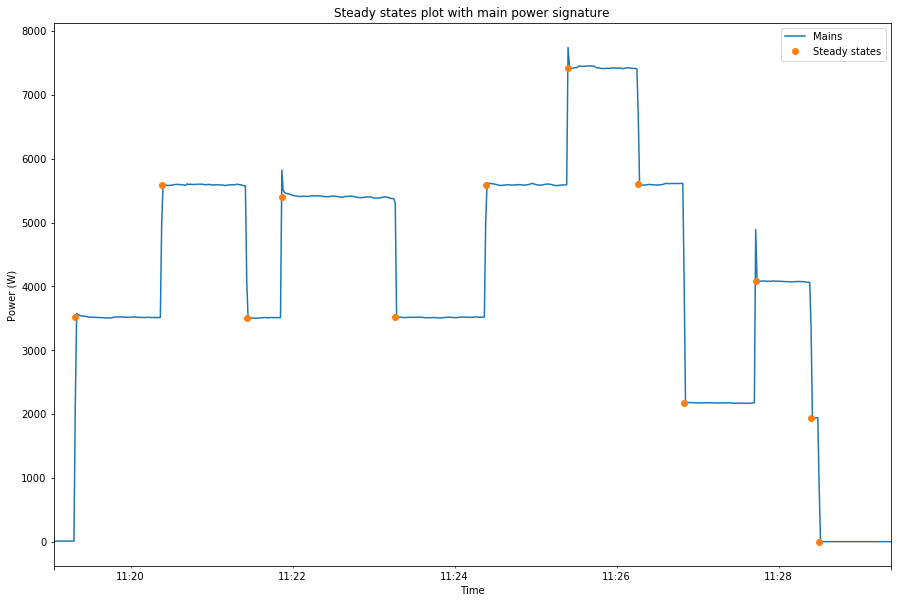

In [13]:
# Plot steady states with main
ax = df_main.plot()
obj_hart.steady_states.plot(style='o', ax = ax);

plt.title("Steady states plot with main power signature")
plt.legend(["Mains", "Steady states"]);
plt.ylabel("Power (W)")
plt.xlabel("Time")

In [14]:
obj_hart.pair_df

T1 Time    T1 Active             T2 Time    T2 Active
0 2022-11-22 11:20:23  2071.200950 2022-11-22 11:21:26 -2084.297418
0 2022-11-22 11:21:52  1898.950844 2022-11-22 11:23:16 -1891.878880
0 2022-11-22 11:25:24  1828.380000 2022-11-22 11:26:16 -1817.455871
0 2022-11-22 11:19:19  3506.770161 2022-11-22 11:26:50 -3424.499225
0 2022-11-22 11:24:23  2077.901970 2022-11-22 11:28:24 -2136.140667
0 2022-11-22 11:27:43  1901.528013 2022-11-22 11:28:30 -1937.976377

In [15]:
# Compute avg of paired transitions using the formula (as in pair_transitions function in pairing module)
pair_shape_df = pd.DataFrame(columns=['Height (W)','Duration (s)'])
pair_shape_df['Height (W)']= (obj_hart.pair_df['T1 Active'].abs()+obj_hart.pair_df['T2 Active'].abs())/2
pair_shape_df['Duration (s)']= pd.to_timedelta(obj_hart.pair_df['T2 Time']-obj_hart.pair_df['T1 Time'],unit='s').dt.seconds

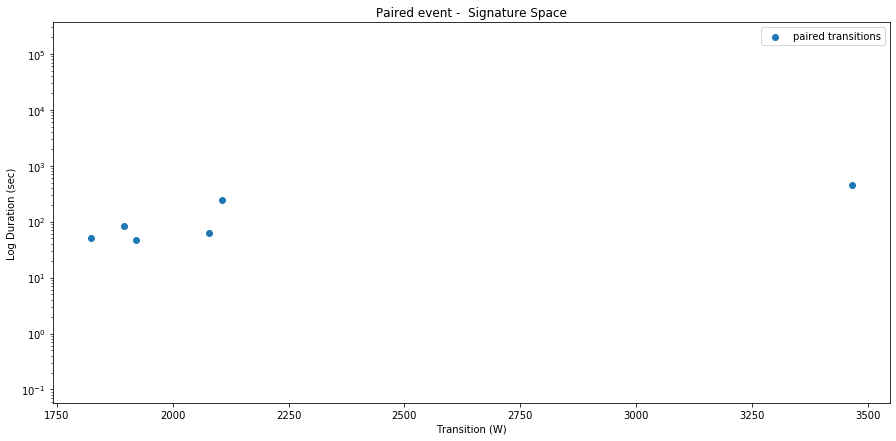

In [16]:
# Plot paired event space
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1, 1, 1)

# Time in log scale
ax.set_yscale('log')

# Plot paired transitions
ax.scatter(pair_shape_df['Height (W)'],pair_shape_df['Duration (s)'], label='paired transitions')

plt.title("Paired event -  Signature Space")
plt.legend()
plt.ylabel("Log Duration (sec)")
plt.xlabel("Transition (W)");

### Clustering
Using hart85_means_shift_cluster function from Hart85
- Mean Shift Clustering is done to determine which pairs of transitions are to which centroid (predicted appliances)
- The algorithm uses sklearn's mean shift clustering method
- Hart85 is unsupervised, therefore there is no labelling in the final centroid(s)

**Steps for clustering:**
1. Compute average absolute value of paired transitions summation:
    - (|T1 Active| + |T2 Active|)/2
2. Cluster: - automatically estimate bandwidth
3. Find bin seeds/kernel (starting points for finding the final centroids)
4. Execute iterations on all seeds (points shifting iteratively towards the attraction nodes)
5. Get centroids (the final nodes)

In [17]:
obj_hart.centroids

(power, active)
0      3465.634693
1      2107.021318
2      2077.749184
3      1919.752195
4      1895.414862
5      1822.917936

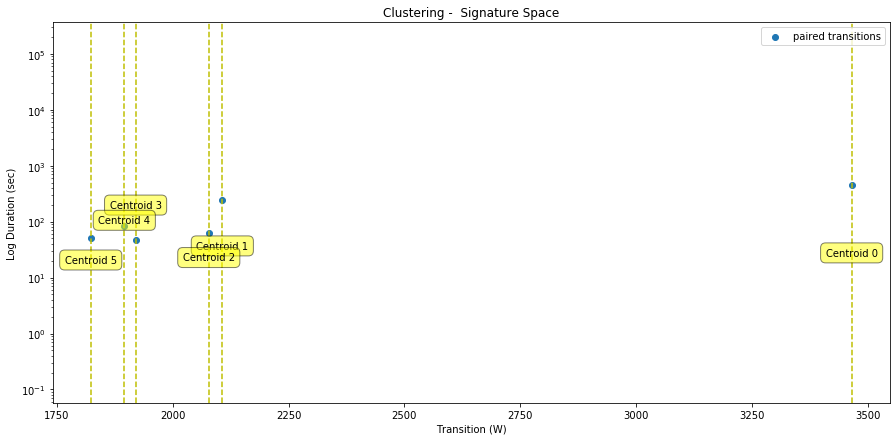

In [18]:
# Plot centroids
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1, 1, 1)

# Time in log scale
ax.set_yscale('log')

# Plot paired transitions
ax.scatter(pair_shape_df['Height (W)'],pair_shape_df['Duration (s)'], label='paired transitions')

# Lines for centroids
for i, row in obj_hart.centroids.iterrows():
    ax.axvline(obj_hart.centroids.iloc[i][0],color = 'y', linestyle='--')

plt.legend(loc=1)
plt.title("Clustering -  Signature Space")
plt.ylabel("Log Duration (sec)")
plt.xlabel("Transition (W)");

# Adding annotation for centroids
labels = ['Centroid {0}'.format(i) for i in range(len(obj_hart.centroids))]
for label, x, y in zip(labels, obj_hart.centroids[('power','active')], pair_shape_df['Duration (s)']):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (0, -20),
        textcoords = 'offset points', ha = 'center', va = 'center',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))

**Note:** Eventhough there is only 3 appliances in the load, 6 centroids are formed in the end, reasons might be one of below:
1. Threshold value is too small
2. Cluster bandwidth is too small

Further experimentation should be made to figure this out

## Export trained model
- The trained model is made by accumulating relevant information from variables according to the steps like finding transient states, pairing and clustering
    
- Model is exported using **pickle** where it can be used to disaggregate load 

In [19]:
def export_model(filename):
    example_dict = obj_hart.model
    with open(filename, "wb") as pickle_out:
        pickle.dump(example_dict, pickle_out)

In [20]:
export_model('trained_model/modelTrainedhart_ke+vac+wh.pickle')

# Dataset preparation - Testing
Changing lab power data into df that can feed into NILMTK 

- Data     : kettle + vacuum + water heater: has main, kettle, vacuum, water heater load data
- Frequency: 1Hz
- Duration : 4mins 47s
- Data type: active power only

In [21]:
# Load main
main_df=pd.read_csv("../Lab_Dataset/3combi_kettle+vacuum+wheater/test_data/main.csv", index_col=0)

# Load submeters
kettle_df=pd.read_csv("../Lab_Dataset/3combi_kettle+vacuum+wheater/test_data/kettle.csv", index_col=0)
vacuum_df=pd.read_csv("../Lab_Dataset/3combi_kettle+vacuum+wheater/test_data/vacuum.csv", index_col=0)
wh_df=pd.read_csv("../Lab_Dataset/3combi_kettle+vacuum+wheater/test_data/water_heater.csv", index_col=0)

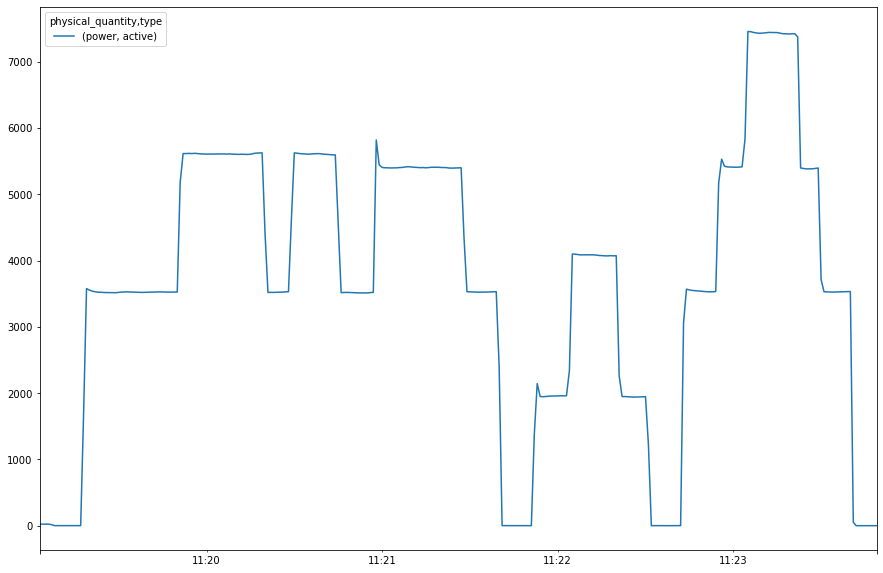

In [22]:
# Convert lab data to multiIndex df
# set column
columns = pd.MultiIndex.from_tuples([('power','active')])

# main
df_main = get_multiIndex(main_df, columns)
# Kettle
df_ke = get_multiIndex(kettle_df, columns)
# Vacuum
df_vac = get_multiIndex(vacuum_df, columns)
# Water Heater
df_wh = get_multiIndex(wh_df, columns)

df_main
df_main.plot()

In [23]:
# Append appliances into one list
appliance_readings = []
appliance_readings.append(df_ke)
appliance_readings.append(df_vac)
appliance_readings.append(df_wh)

# Aggregated load is already in mains, no need to artificial aggregate
test_df = df_main

test_submeters = [[] for i in range(len(appliances))]
test_mains = []

test_mains.append(test_df)
for i,name in enumerate(appliances):
    test_submeters[i].append(appliance_readings[i])

appliance_readings = []
for i,appliance_name in enumerate(appliances):
    appliance_readings.append((appliance_name, test_submeters[i]))

test_submeters = appliance_readings 

# Testing
The **disaggregation process** includes the steps:
1. Find transient states
2. Disaggregate by chunk

## Import trained model
Import the previously trained model using the kettle+vacuum+wh 10 mins data

In [24]:
def import_model(filename):
    with open(filename, "rb") as pickle_in:
        model = pickle.load(pickle_in)
        #states = model['states']
        #appliance_name = model['appliance_name']
    return model

In [25]:
model = import_model('trained_model/modelTrainedhart_ke+vac+wh.pickle')

obj_hart.model = model

## Predict function
- The overall predict function to run the  main processes for disaggregation

In [26]:
def predict(test_mains, test_submeters):
    print ("Generating predictions for :",MODEL_NAME)        
    """
    Generates predictions on the test dataset using the specified classifier.
    """  
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.   
    # disag_chunk call
    pred_list = disaggregate_chunk(test_mains)

    # It might not have time stamps sometimes due to neural nets
    # It has the readings for all the appliances

    concat_pred_df = pd.concat(pred_list,axis=0)

    gt = {}
    for meter,data in test_submeters:
        concatenated_df_app = pd.concat(data,axis=1)
        index = concatenated_df_app.index
        gt[meter] = pd.Series(concatenated_df_app.values.flatten(),index=index)

    gt_overall = pd.DataFrame(gt, dtype='float32')
    pred = {}

    for app_name in concat_pred_df.columns:
        app_series_values = concat_pred_df[app_name].values.flatten()
        # Neural nets do extra padding sometimes, to fit, so get rid of extra predictions
        app_series_values = app_series_values[:len(gt_overall[app_name])]
        pred[app_name] = pd.Series(app_series_values, index = gt_overall.index)
    pred_overall = pd.DataFrame(pred,dtype='float32')
        
    return gt_overall, pred_overall

## Disaggregate chunk function
### Find states
Using find_steady_states_transients function from Hart85

**Steps to find states:**
    
1. The algorithm will mark the changes in power, if it is higher than the state_threshold, then a transition is happening and the values will be calculated based on the estimated steady state
2. The transients are found by taking the difference between 2 measurements and goes through a nested If:
    - If state change > threshold, then detect that there is transition happening
    - If transition > noise level, then record the transition and steady states
- Transitions are recorded as positive when power is going up and negative when power is going down
- The start of steady states are used as edges for the state change
- Returns the lists of recorded transient and steady states into Dataframe

**Steps for disaggregation:**

1. Hart85 disaggregate algorithm takes power data chunk by chunk (according to how much the memory is able to compute at one time)
2. Transient state is taken one by one at a time
3. The state is compared to the centroid(s) from trained model
4. The min value of the difference is extracted to figure out to which centroid the state belongs to
5. Power is then assigned to chunk according to power value from centroid (for load disaggregation)
    - Each disaggregated 'appliances' will have predicted load values according to chunk's timestamp
- Returns the DataFrame of disaggregated 'appliances' with their power values

In [27]:
def disaggregate_chunk(test_mains):  
    """
    Parameters
    ----------
    chunk : pd.DataFrame
        mains power
    prev
    transients : returned by find_steady_state_transients

    Returns
    -------
    states : pd.DataFrame
        with same index as `chunk`.
    """
    #print(test_mains)
    test_predictions_list = []
        
    for chunk in test_mains:
          
        [_, transients] = find_steady_states(
        test_mains[0],  state_threshold=obj_hart.state_threshold,
        noise_level=obj_hart.noise_level)
        
        obj_hart.disag_steady = _
        obj_hart.disag_trans = transients
        #print('Transients:',transients)
        # For now ignoring the first transient
        # transients = transients[1:]

        # Initially all appliances/meters are in unknown state (denoted by -1)
        prev = OrderedDict()
        learnt_meters = obj_hart.centroids.index.values
        for meter in learnt_meters:
            prev[meter] = -1
        states = pd.DataFrame(
            -1, index=chunk.index, columns=obj_hart.centroids.index.values)
        #print('STATES:',states)    
        for transient_tuple in transients.itertuples():
            if transient_tuple[0] < chunk.index[0]:
                # Transient occurs before chunk has started; do nothing
                pass
            elif transient_tuple[0] > chunk.index[-1]:
                # Transient occurs after chunk has ended; do nothing
                pass
            else:
                # Absolute value of transient
                abs_value = np.abs(transient_tuple[1:])
                positive = transient_tuple[1] > 0
                abs_value_transient_minus_centroid = pd.DataFrame(
                    (obj_hart.centroids - abs_value).abs())
                if len(transient_tuple) == 2:
                    # 1d data
                    index_least_delta = (abs_value_transient_minus_centroid.idxmin().values[0])
                else:
                    # 2d data.
                    # Need to find absolute value before computing minimum
                    columns = abs_value_transient_minus_centroid.columns
                    abs_value_transient_minus_centroid["multidim"] = (
                        abs_value_transient_minus_centroid[columns[0]] ** 2
                        +
                        abs_value_transient_minus_centroid[columns[1]] ** 2)
                    index_least_delta = (
                        abs_value_transient_minus_centroid["multidim"].idxmin())
                if positive:
                    # Turned on
                    states.loc[transient_tuple[0]][index_least_delta] = 1
                else:
                    # Turned off
                    states.loc[transient_tuple[0]][index_least_delta] = 0
        prev = states.iloc[-1].to_dict()
        power_chunk_dict = obj_hart.assign_power_from_states(states, prev)
        obj_hart.power_dict = power_chunk_dict
        obj_hart.chunk_index = chunk.index
        # Check whether 1d data or 2d data and converting dict to dataframe
        if len(transient_tuple) == 2:
            temp_df = pd.DataFrame(power_chunk_dict, index=chunk.index)  
        else:
            tuples = []

            for i in range(len(obj_hart.centroids.index.values)):
                for j in range(0, 2):
                    tuples.append([i, j])

            columns = pd.MultiIndex.from_tuples(tuples)

            temp_df = pd.DataFrame(
                power_chunk_dict,
                index=chunk.index,
                columns=columns)

            for i in range(len(chunk.index)):
                for j in range(len(obj_hart.centroids.index.values)):
                    for k in range(0, 2):
                        temp_df.iloc[i,j,k] = power_chunk_dict[j,i,k]
         
    temp_df=temp_df.fillna(0)
 
    temp=pd.DataFrame()
    for appliance in obj_hart.appliances:
        matched_col=obj_hart.best_matches[appliance]
        temp[appliance]=temp_df[matched_col]
    test_predictions_list.append(temp)    
          
    return test_predictions_list

## Generate prediction/disaggregation

In [28]:
pred_overall={}
gt_overall={} 

#Start predicting
start_time = time.time()
gt_overall,pred_overall=predict(test_mains,test_submeters)
print("---Runtime: %s seconds ---" % (time.time() - start_time))

Generating predictions for : Hart85
Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.
---Runtime: 0.07864117622375488 seconds ---


/opt/conda/envs/nilmtk-env/lib/python3.7/site-packages/nilmtk/disaggregate/hart_85.py:529: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  power[i] = self.centroids.ix[appliance].values
/opt/conda/envs/nilmtk-env/lib/python3.7/site-packages/nilmtk/disaggregate/hart_85.py:532: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  power[i] = self.centroids.ix[appliance].values


### Results: Show states
- To check the recorded transitions and steady states
- Showing the edges when steady states start

In [29]:
obj_hart.disag_steady

active average
2022-11-22 11:19:18     3522.873000
2022-11-22 11:19:51     5609.049643
2022-11-22 11:20:20     3522.786250
2022-11-22 11:20:29     5607.002667
2022-11-22 11:20:45     3515.319167
2022-11-22 11:20:58     5402.080357
2022-11-22 11:21:28     3525.939091
2022-11-22 11:21:40        1.355455
2022-11-22 11:21:52     1955.164000
2022-11-22 11:22:04     4081.353750
2022-11-22 11:22:21     1944.330000
2022-11-22 11:22:31        1.309091
2022-11-22 11:22:43     3540.920000
2022-11-22 11:22:55     5411.578571
2022-11-22 11:23:04     7432.168235
2022-11-22 11:23:22     5387.905714
2022-11-22 11:23:30     3527.812000
2022-11-22 11:23:41        1.108750

In [30]:
obj_hart.disag_trans

active transition
2022-11-22 11:19:18        3521.181000
2022-11-22 11:19:51        2086.176643
2022-11-22 11:20:20       -2086.263393
2022-11-22 11:20:29        2084.216417
2022-11-22 11:20:45       -2091.683500
2022-11-22 11:20:58        1886.761190
2022-11-22 11:21:28       -1876.141266
2022-11-22 11:21:40       -3524.583636
2022-11-22 11:21:52        1953.808545
2022-11-22 11:22:04        2126.189750
2022-11-22 11:22:21       -2137.023750
2022-11-22 11:22:31       -1943.020909
2022-11-22 11:22:43        3539.610909
2022-11-22 11:22:55        1870.658571
2022-11-22 11:23:04        2020.589664
2022-11-22 11:23:22       -2044.262521
2022-11-22 11:23:30       -1860.093714
2022-11-22 11:23:41       -3526.703250

Text(0.5, 0, 'Time')

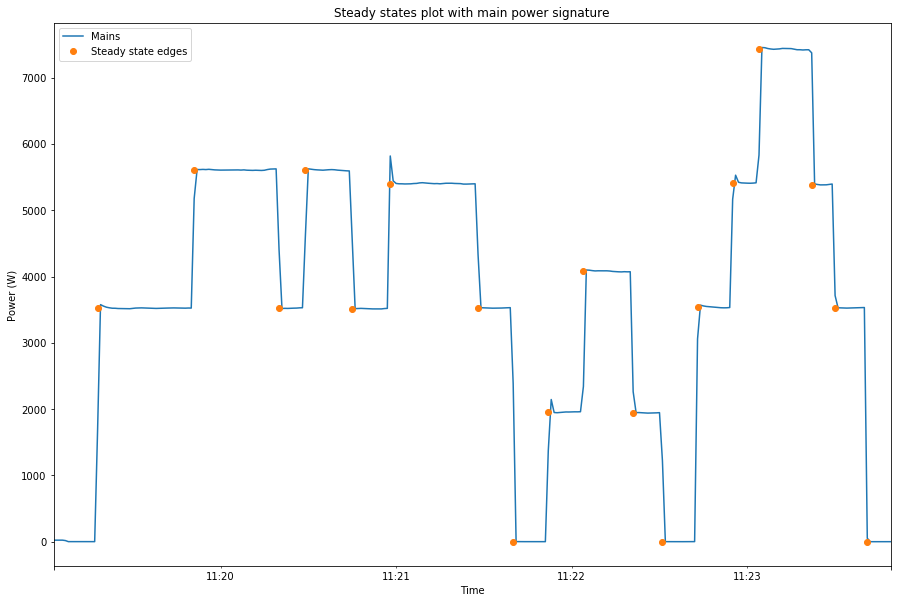

In [31]:
# Plot steady states with main
ax = df_main.plot()
obj_hart.disag_steady.plot(style='o', ax = ax);

plt.title("Steady states plot with main power signature")
plt.legend(["Mains", "Steady state edges"]);
plt.ylabel("Power (W)")
plt.xlabel("Time")

# Data visualization
To compare the ground truth vs predicted appliance loads

## Ground Truth

In [32]:
# Get steady state points to plot
x=gt_overall.index
ke_val = gt_overall['kettle'].values
vac_val = gt_overall['vacuum'].values
wh_val = gt_overall['water heater'].values

# Kettle steady state point
ke_ss = gt_overall.iloc[90]['kettle']
x_ke = np.where(ke_val==ke_ss)
x_ke = x[x_ke]

# Vacuum steady state point
vac_ss = gt_overall.iloc[180]['vacuum']
x_vac = np.where(vac_val==vac_ss)
x_vac = x[x_vac]

# Water heater steady state point
wh_ss = gt_overall.iloc[50]['water heater']
x_wh = np.where(wh_val==wh_ss)
x_wh = x[x_wh]

Text(5, 10, '3448.61')

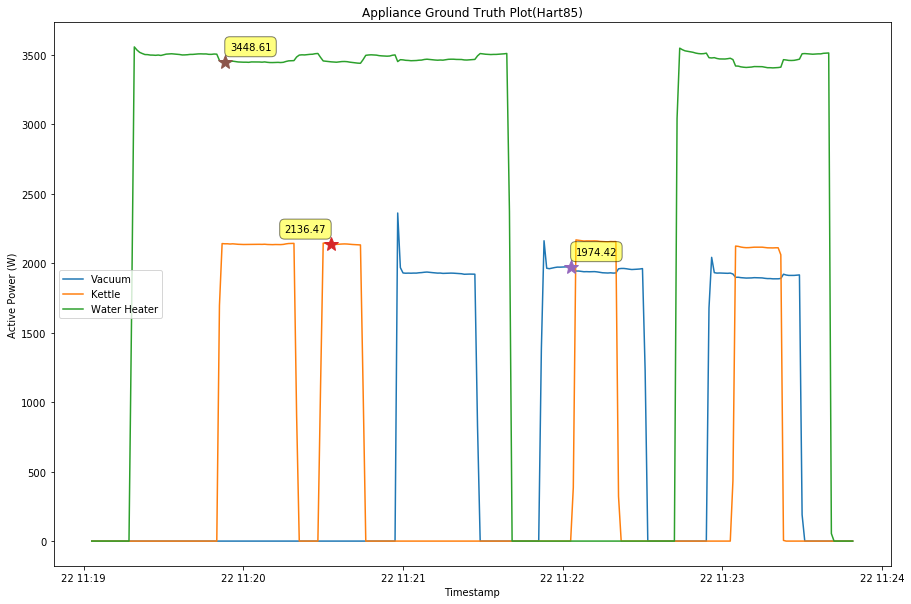

In [33]:
# Plot GT 
gt_vac = plt.plot(gt_overall.index, gt_overall['vacuum'], label = 'Vacuum')
gt_ke = plt.plot(gt_overall.index, gt_overall['kettle'], label = 'Kettle')
gt_wh = plt.plot(gt_overall.index, gt_overall['water heater'], label = 'Water Heater')
point1 = plt.plot(x_ke[0],ke_ss,marker="*",markersize=15)
point2 = plt.plot(x_vac[0],vac_ss,marker="*",markersize=15)
point3 = plt.plot(x_wh[0],wh_ss,marker="*",markersize=15)

plt.title("Appliance Ground Truth Plot(Hart85)")
plt.legend()
plt.ylabel("Active Power (W)")
plt.xlabel("Timestamp")

# annotate kettle point
plt.annotate(
        ke_ss, 
        xy = (x_ke[0], ke_ss), xytext = (-5, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))
# annotate vacuum point
plt.annotate(
        vac_ss, 
        xy = (x_vac[0], vac_ss), xytext = (5, 10),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))
# annotate water heater point
plt.annotate(
        wh_ss, 
        xy = (x_wh[0], wh_ss), xytext = (5, 10),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))

## Predicted
- Plot out the disaggregated 'appliances' output to visualize the predicted disaggregated loads

In [34]:
# Get steady state points to plot
x=pred_overall.index
ke_val = pred_overall['kettle'].values
vac_val = pred_overall['vacuum'].values
wh_val = pred_overall['water heater'].values

# Kettle steady state point
ke_ss = pred_overall.iloc[100]['kettle']
x_ke = np.where(ke_val==ke_ss)
x_ke = x[x_ke]

# Vacuum steady state point
vac_ss = pred_overall.iloc[250]['vacuum']
x_vac = np.where(vac_val==vac_ss)
x_vac = x[x_vac]

# Water heater steady state point
wh_ss = pred_overall.iloc[100]['water heater']
x_wh = np.where(wh_val==wh_ss)
x_wh = x[x_wh]

Text(5, 10, '3465.0')

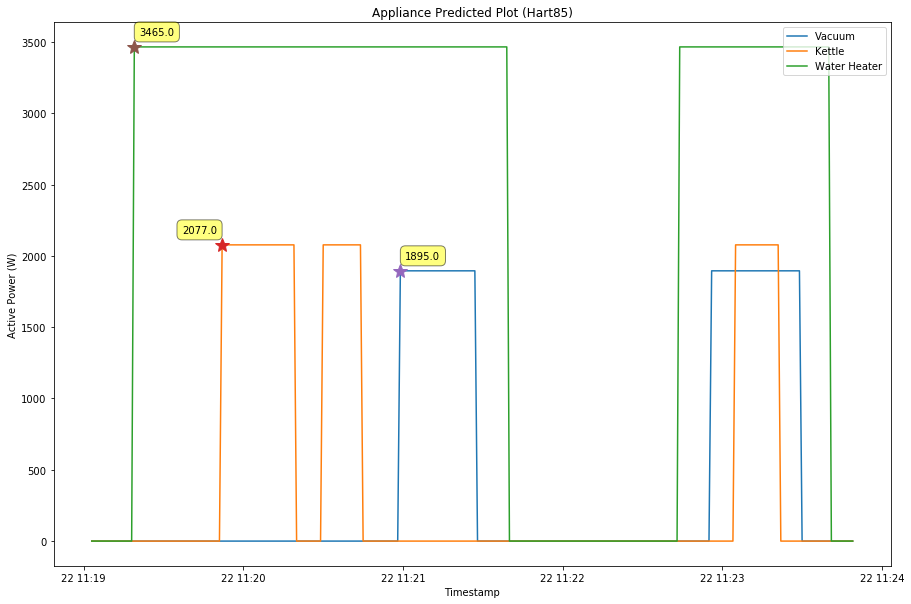

In [35]:
# Plot Predicted 
pred_vac = plt.plot(pred_overall.index, pred_overall['vacuum'], label = 'Vacuum')
pred_ke = plt.plot(pred_overall.index, pred_overall['kettle'], label = 'Kettle')
pred_wh = plt.plot(pred_overall.index, pred_overall['water heater'], label = 'Water Heater')
point1 = plt.plot(x_ke[0],ke_ss,marker="*",markersize=15)
point2 = plt.plot(x_vac[0],vac_ss,marker="*",markersize=15)
point3 = plt.plot(x_wh[0],wh_ss,marker="*",markersize=15)

plt.title("Appliance Predicted Plot (Hart85)")
plt.legend(loc=1)
plt.ylabel("Active Power (W)")
plt.xlabel("Timestamp")

# annotate kettle point
plt.annotate(
        ke_ss, 
        xy = (x_ke[0], ke_ss), xytext = (-5, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))
# annotate vacuum point
plt.annotate(
        vac_ss, 
        xy = (x_vac[0], vac_ss), xytext = (5, 10),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))
# annotate water heater point
plt.annotate(
        wh_ss, 
        xy = (x_wh[0], wh_ss), xytext = (5, 10),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))

In [36]:
obj_hart.centroids

(power, active)
0      3465.634693
1      2107.021318
2      2077.749184
3      1919.752195
4      1895.414862
5      1822.917936

## Main vs Predicted

Text(5, 10, '3465.0')

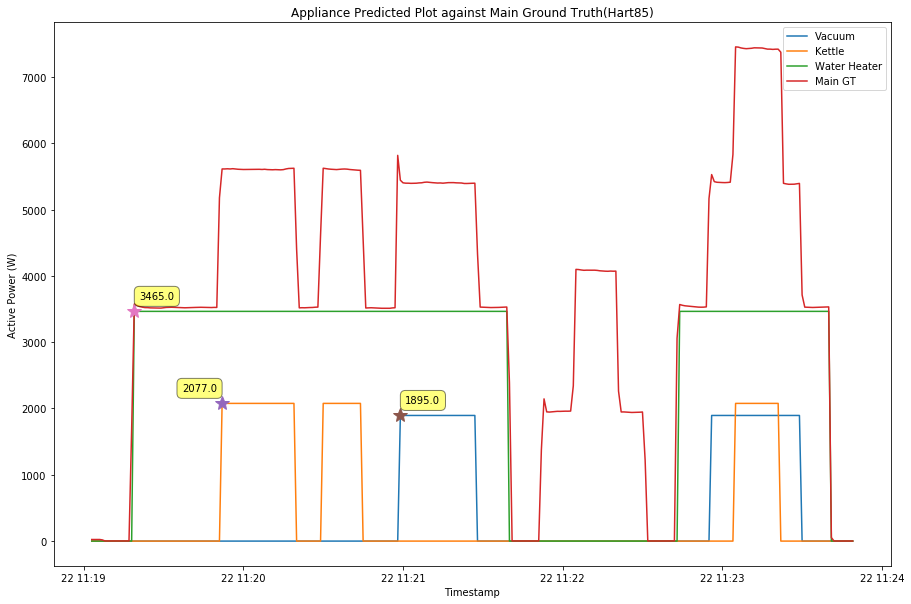

In [37]:
# Plot Predicted vs GT Main
pred_vac = plt.plot(pred_overall.index, pred_overall['vacuum'], label = 'Vacuum')
pred_ke = plt.plot(pred_overall.index, pred_overall['kettle'], label = 'Kettle')
pred_wh = plt.plot(pred_overall.index, pred_overall['water heater'], label = 'Water Heater')
pred_main = plt.plot(df_main, label = 'Main GT')
point1 = plt.plot(x_ke[0],ke_ss,marker="*",markersize=15)
point2 = plt.plot(x_vac[0],vac_ss,marker="*",markersize=15)
point3 = plt.plot(x_wh[0],wh_ss,marker="*",markersize=15)

plt.title("Appliance Predicted Plot against Main Ground Truth(Hart85)")
plt.legend(loc=1)
plt.ylabel("Active Power (W)")
plt.xlabel("Timestamp")

# annotate kettle point
plt.annotate(
        ke_ss, 
        xy = (x_ke[0], ke_ss), xytext = (-5, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))
# annotate vacuum point
plt.annotate(
        vac_ss, 
        xy = (x_vac[0], vac_ss), xytext = (5, 10),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))
# annotate water heater point
plt.annotate(
        wh_ss, 
        xy = (x_wh[0], wh_ss), xytext = (5, 10),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))

## Ground vs Predicted

Text(0.5, 0, 'Timestamp')

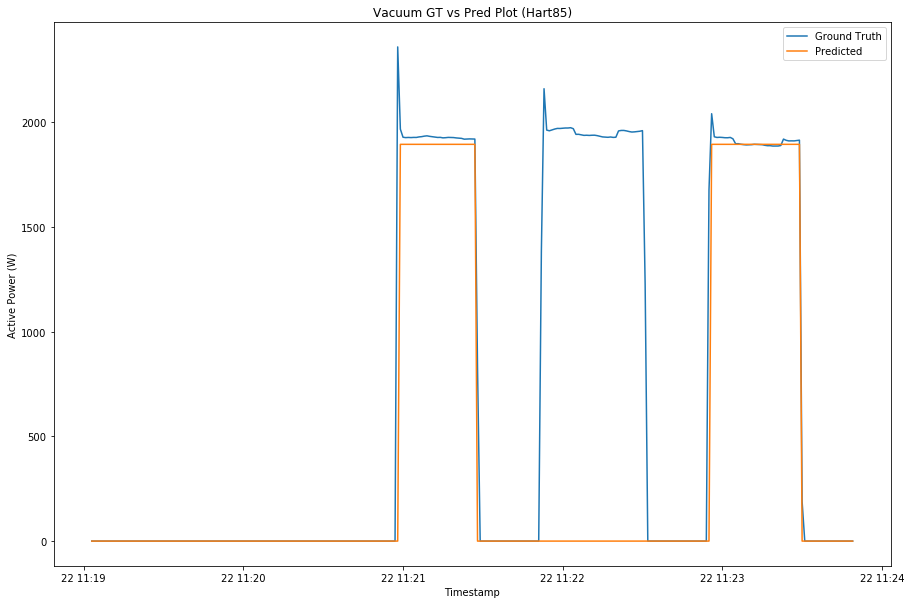

In [38]:
# Plot Vacuum
gt_vac = plt.plot(gt_overall.index, gt_overall['vacuum'], label = 'Ground Truth')
pred_vac = plt.plot(pred_overall.index, pred_overall['vacuum'], label = 'Predicted')

plt.title("Vacuum GT vs Pred Plot (Hart85)")
plt.legend()
plt.ylabel("Active Power (W)")
plt.xlabel("Timestamp")

Text(0.5, 0, 'Timestamp')

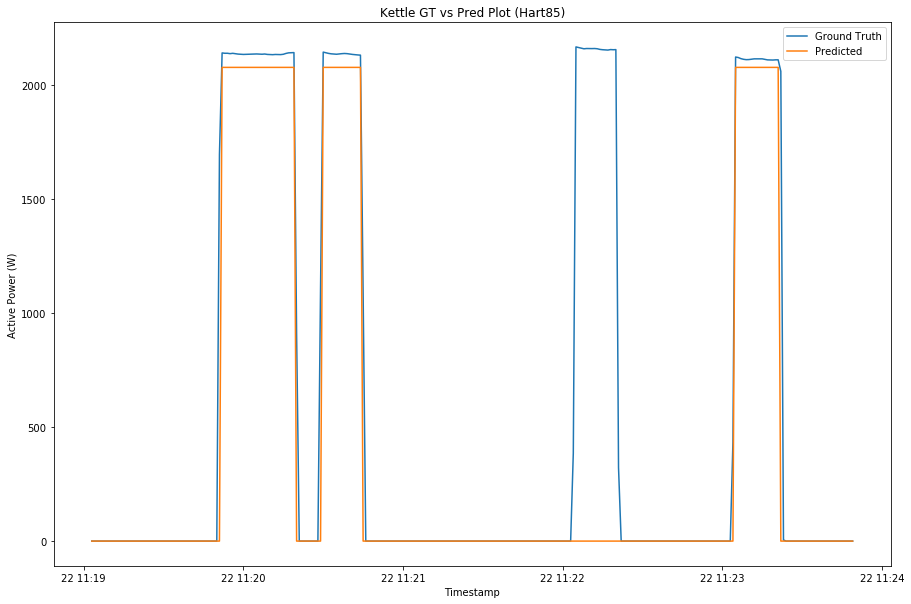

In [39]:
# Plot Kettle
gt_ke = plt.plot(gt_overall.index, gt_overall['kettle'], label = 'Ground Truth')
pred_ke = plt.plot(pred_overall.index, pred_overall['kettle'], label = 'Predicted')

plt.title("Kettle GT vs Pred Plot (Hart85)")
plt.legend()
plt.ylabel("Active Power (W)")
plt.xlabel("Timestamp")

Text(0.5, 0, 'Timestamp')

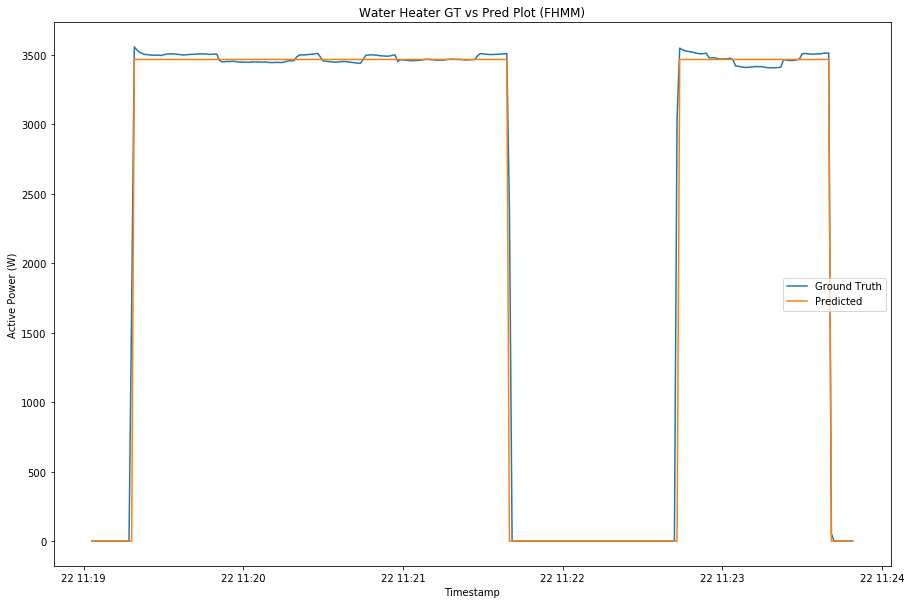

In [40]:
# Plot Water Heater
gt_wh = plt.plot(gt_overall.index, gt_overall['water heater'], label = 'Ground Truth')
pred_wh = plt.plot(pred_overall.index, pred_overall['water heater'], label = 'Predicted')

plt.title("Water Heater GT vs Pred Plot (FHMM)")
plt.legend()
plt.ylabel("Active Power (W)")
plt.xlabel("Timestamp")

# Evaluation Metrics
- Evaluations metrics are used to evaluate how well the prediction is done by the trained model.
- The predicted disaggregated load(s) are evaluated using a few evaluation metrics for regression loss:
    1. **MSE**
    2. **RMSE**
    3. **MAE**
    4. **MAPE**
- Computed results shows the error/loss values of predicted to ground truth
    - The pair with the least loss is considered the closest prediction or the more accurate prediction to ground truth
    
1. **Mean Squared Error (MSE)**
    - The mean squared error (MSE) tells you how close a regression line is to a set of points. It does this by taking the distances from the points to the regression line (these distances are the “errors”) and squaring them. It’s called the mean squared error as you’re finding the average of a set of errors. The lower the MSE, the better the prediction.
     
2. **Root Mean Squared Error (RMSE)**
    - Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit.
    
3. **Mean absolute error (MAE)**
    - Computes the mean of squares of errors between labeled data and predicted data. It calculates the absolute difference between the current output and the expected output divided by the number of output.
    
4. **Mean absolute percentage error (MAPE)**
    - is a measure of prediction accuracy of a forecasting method in statistics. It measures this accuracy as a percentage, and can be calculated as the average absolute percent error for each time period minus actual values divided by actual values.

In [41]:
def rmse(gt,pred):
    val = np.sqrt(mean_squared_error(gt,pred))
    return val

In [42]:
metrics = [mean_squared_error, rmse, mean_absolute_error, mean_absolute_percentage_error]
metrics_label = ['MSE','RMSE' ,'MAE', 'MAPE']

# Show metrics
for metric,lbl in zip(metrics,metrics_label):
    try:
        loss_function = metric
    except:
        print ("Loss function ",metric, " is not supported currently!")
        continue

    error = {}
    for app_name in gt_overall.columns:
        error[app_name] = loss_function(gt_overall[app_name],pred_overall[app_name])
    
    error = pd.Series(error)
    computed_metric = pd.DataFrame(error)
    print("............ " ,lbl," ..............")
    print(computed_metric.to_string(header=False))
    print("\n")

............  MSE  ..............
kettle        297831.437500
vacuum        551086.750000
water heater   62349.210938


............  RMSE  ..............
kettle        545.739380
vacuum        742.352173
water heater  249.698242


............  MAE  ..............
kettle        159.196762
vacuum        291.300629
water heater   43.729828


............  MAPE  ..............
kettle        0.102722
vacuum        0.159628
water heater  0.029807




# Conclusion
- Train: kettle+vacuum+water_heater - 10 min data
- Test & disaggregate : kettle+vacuum+water_heater 4 mins data

1. Able to detect the appliances correctly
2. 3 combination seems complicated for Hart85 to disaggregate properly

- Expected: Able to classify the appliances properly
- Result: Some errors in appliance activations as seen for vacuum and kettle